In [1]:
%matplotlib inline
DEFAULT_FIGSIZE = (12, 8)

import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd

sys.path.append('..')
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

In [2]:
braking_df = pd.read_pickle('braking_ttc.p.gz')
steering_df = pd.read_pickle('steering_ttc.p.gz')

(<matplotlib.figure.Figure at 0x10f425a58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f4ea2e8>)

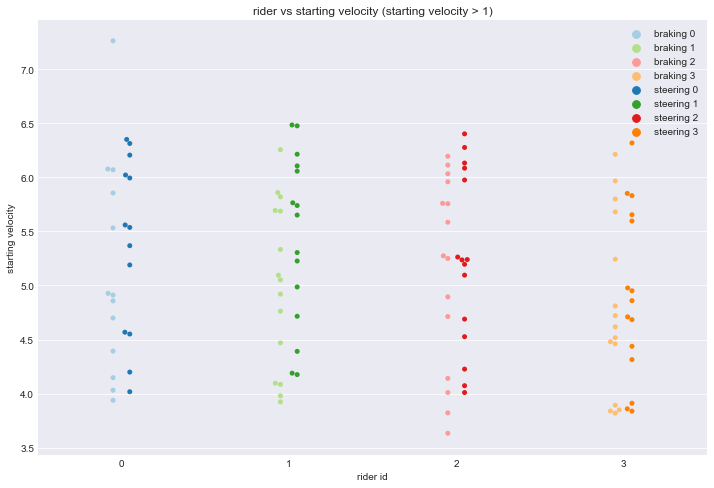

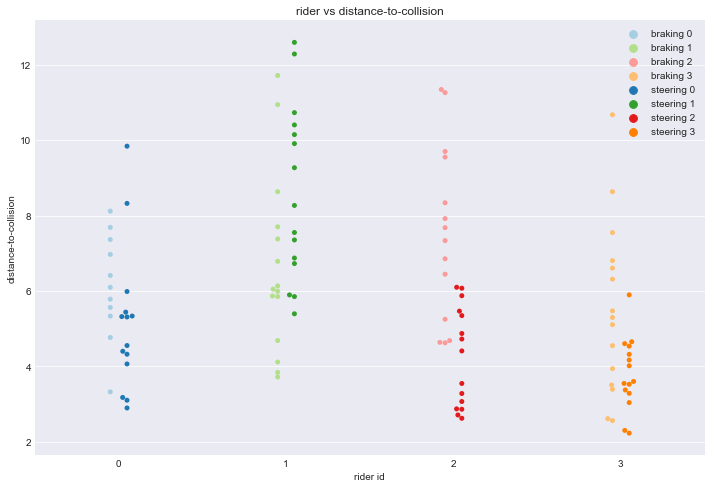

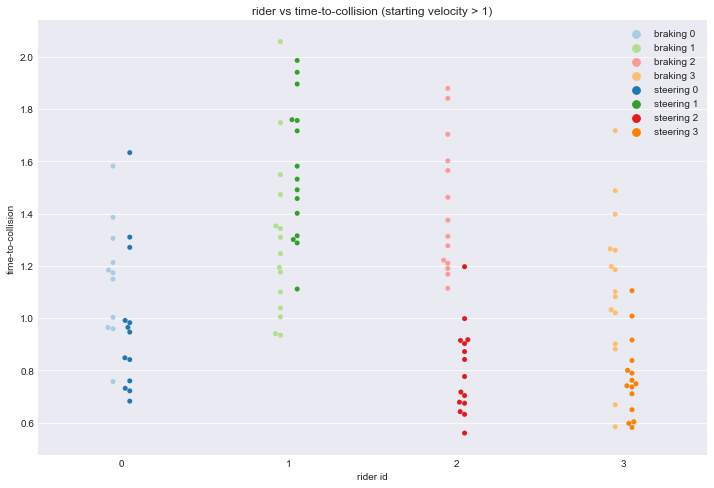

In [3]:
#%matplotlib notebook
#mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

def set_swarmplot_labels(ax, event_types):
    handles, labels = ax.get_legend_handles_labels()
    n = len(labels)
    assert n % 2 == 0 # check if even
    
    labels = ['{} {}'.format(event_type, rider_id)
              for event_type, rider_id in itertools.product(
                  event_types, labels[:n//2])]
    
    ax.legend(handles, labels)
    
def shift_swarmplot(ax, shift_value=0.05):
    collections = ax.collections
    n = len(collections)
    
    # collections are ordered as:
    # [c0, c1, c2, c3, x, x, x, x,
    #  c4, c5, c7, c6, x, x, x, x]
    collections = [c for i, c in enumerate(collections)
                   if (i//n) % n//4 == 0]
    
    for i, c in enumerate(collections):
        if i < n//4:
            sign = -1
        else:
            sign = 1
        
        offsets = c.get_offsets()
        shifts = np.matlib.repmat(
            np.array([[sign*shift_value, 0]]),
            offsets.shape[0], 1)
        
        c.set_offsets(offsets + shifts)
            
def plot_combined_swarm(y, df_filter=None):
    """
    y: dataframe column
    df_filter: dataframe filter function, description
    """
    color_map = sns.color_palette('Paired', 10)
    fig, ax = plt.subplots()
    
    def apply_filter(df):
        if df_filter is None:
            return df
        else:
            f = df_filter[0]
            return df[f(df)]
    
    sns.swarmplot(x='rider id', y=y, data=apply_filter(braking_df), ax=ax,
                  hue='rider id', palette=color_map[::2])
    sns.swarmplot(x='rider id', y=y, data=apply_filter(steering_df), ax=ax,
                  hue='rider id', palette=color_map[1::2])
    
    set_swarmplot_labels(ax, ['braking', 'steering'])
    shift_swarmplot(ax)

    title = 'rider vs {}'.format(y)
    if df_filter is not None:
        title = '{} ({})'.format(title, df_filter[1])
    ax.set_title(title) 
    return fig, ax

# dataframe filter
valid_velocities = (lambda x: x['starting velocity'] > 1,
                    'starting velocity > 1')
    
plt.close('all')

fig, ax = plot_combined_swarm('starting velocity', valid_velocities)
plot_combined_swarm('distance-to-collision')
plot_combined_swarm('time-to-collision', valid_velocities)

#plt.show()